In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from torchinfo import summary


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Dataset & Dataloader

In [3]:
class CustomDataset(Dataset):

    def __init__(self, dataset, transform=None):
        self.data, self.targets = self.split_data_with_targets(dataset)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # grab the data
        image = self.data[index]
        label = self.targets[index]

        # check for transform
        if self.transform is not None:
            image = self.transform(image)

        return image, torch.FloatTensor([label])

    def split_data_with_targets(self, dataset):
        images = []
        labels = []
        for image, label in dataset:
            images.append(image)
            labels.append(label)
        return images, labels

In [4]:
# resize the image and transform to tensor
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root="cats-breads/")
custom_dataset = CustomDataset(dataset=dataset, transform=transformations)

In [5]:
# Stratified Sampling for train and val
train_idx, test_idx = train_test_split(np.arange(len(custom_dataset)),
                                             test_size=0.2,
                                             random_state=1,
                                             shuffle=True,
                                             stratify=custom_dataset.targets)

# Subset dataset for train and val
train_dataset = Subset(custom_dataset, train_idx)
test_dataset = Subset(custom_dataset, test_idx)

In [6]:
train_labels = []
for image, label in train_dataset:
    train_labels.append(label)

test_labels = []
for image, label in test_dataset:
    test_labels.append(label)

train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

Train Dataset size: 1910
Test Dataset size: 478


In [9]:
class_names = dataset.classes
class_names

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx']

### Sainty Check

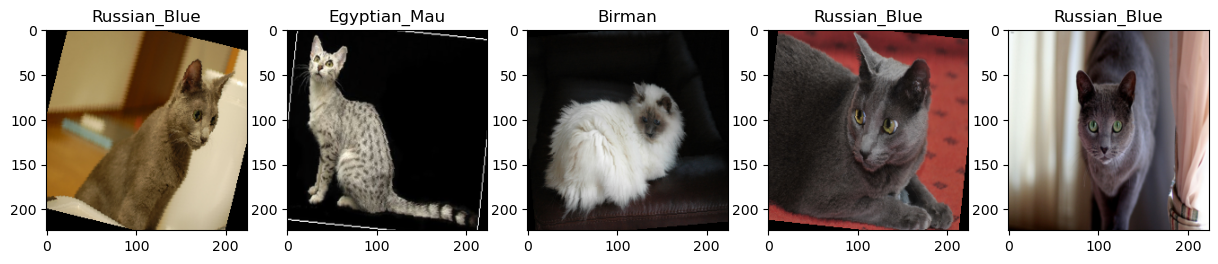

In [10]:
def imshow(images_tensor, labels):

    class_labels = class_names

    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    sanity_check = 5
    if images_tensor.shape[0] < sanity_check:
        sanity_check = images_tensor.shape[0]

    fig, axs = plt.subplots(1, sanity_check, figsize=(15, 7))

    for index in range(sanity_check):

        x = images_tensor[index] * STD[:, None, None] + MEAN[:, None, None]
        axs[index].imshow(x.numpy().transpose(1, 2, 0))
        axs[index].title.set_text(class_labels[int(labels[index])])

    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
example_batch = next(dataiter)

# Separate the batch into images and labels
concatenated_images = example_batch[0]
labels = example_batch[1]
labels = labels.numpy().reshape(-1)

# Show images with labels
imshow(concatenated_images, labels)

Vision Transformer, juga dikenal sebagai ViT, adalah model pembelajaran mendalam yang menerapkan arsitektur Transformer, yang awalnya dikembangkan untuk pemrosesan bahasa alami, untuk tugas-tugas visi komputer. Ia mendapat perhatian karena kemampuannya mencapai kinerja kompetitif pada klasifikasi gambar dan tugas penglihatan lainnya, bahkan tanpa bergantung pada jaringan saraf konvolusional (CNN).

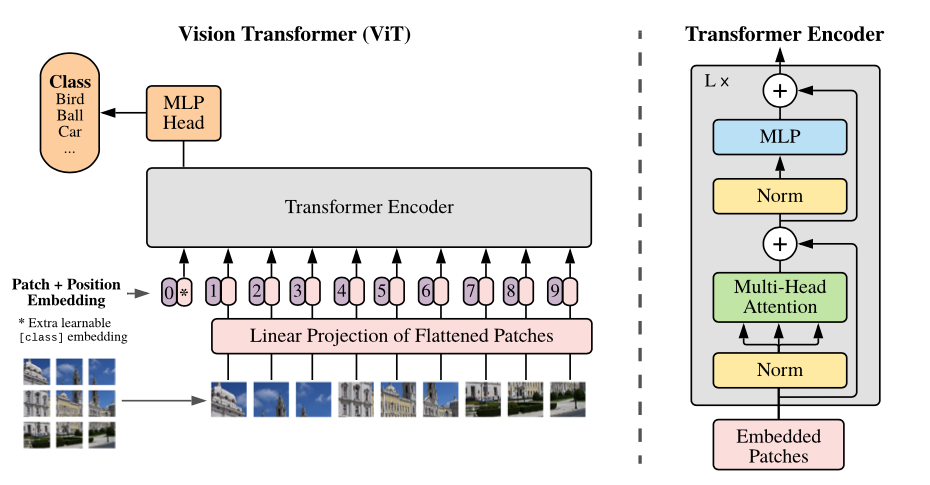

In [11]:
from IPython.display import Image, display

display(Image(filename='gambar/vit.png'))

### Komponen utama dari arsitektur Vision Transfomer :
1 Tokenization Gambar
    - Citra dibagi menjadi sejumlah token / patch.
    - Dilakukan flatten dimasing-masing patch.
2 Positional Embeddings
    Menambahkan urutan token dan menambahkan token ke 0
3 Blok Transfomer
    - Normalisasi
        Normalisasi batch untuk mengontrol distribusi nilai di seluruh mini-batch.
    - Multi Head Attention
        memberikan bobot berbeda disetiap token
        memproses informasi dari token dan memungkinkan memahami hubungan antar token
    - Skip Connection
    - Normalisasi
    - MLP (Multi Layer Preseption)
        menambahkan fungsi aktivasi
    - Skip Connection
4 MLP Head
    Untuk klasifikasi

### Model Vision Transfomer Pretrain

In [12]:
import torch.nn as nn

# 1. Ambil bobot pra-latih untuk ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Buat instansiasi model ViT dengan bobot pra-latih
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Bekukan parameter dasar
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Ganti kepala klasifikasi
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [13]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(8, 3, 224, 224)
) v,v,v 

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [8, 12]                   768
├─Conv2d: 1-1                                 [8, 768, 14, 14]          (590,592)
├─Encoder: 1-2                                [8, 197, 768]             151,296
│    └─Dropout: 2-1                           [8, 197, 768]             --
│    └─Sequential: 2-2                        [8, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [8, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-2                 [8, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-3                 [8, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-4                 [8, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-5                 [8, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-6                 [8, 197, 768]             (7,087,872)
│    │    └─EncoderBlock: 3-

In [14]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [15]:
model = pretrained_vit
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Early stopping setup
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping Counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os

# Training loop dengan early stopping dan checkpoint
num_epochs = 50
best_val_loss = float("inf")
early_stopping = EarlyStopping(patience=3, verbose=True)

checkpoint_dir = "model_checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
# os.makedirs(checkpoint_dir, exist_ok=True)

# Lists untuk menyimpan metrik pelatihan
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for inputs, labels in train_loader:
        labels = labels.view(-1) if len(labels.shape) > 1 else labels

        # Ensure labels has data type torch.long
        labels = labels.type(torch.long)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, train_preds = torch.max(outputs, 1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(train_preds.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.view(-1) if len(labels.shape) > 1 else labels

            # Ensure labels has data type torch.long
            labels = labels.type(torch.long)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, val_preds = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(val_preds.cpu().numpy())

    val_loss /= len(test_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


    # Checkpointing
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), checkpoint_path)

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break


#### Load Model Terbaik

In [19]:
import os
checkpoint_dir = "model_checkpoints"
# Load the best model
best_checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_50.pth")

model.load_state_dict(torch.load(best_checkpoint_path))

<All keys matched successfully>

In [20]:
# Plotting train loss and val loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train accuracy and val accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


NameError: name 'train_losses' is not defined

<Figure size 1000x500 with 0 Axes>

### Evaluasi

In [21]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

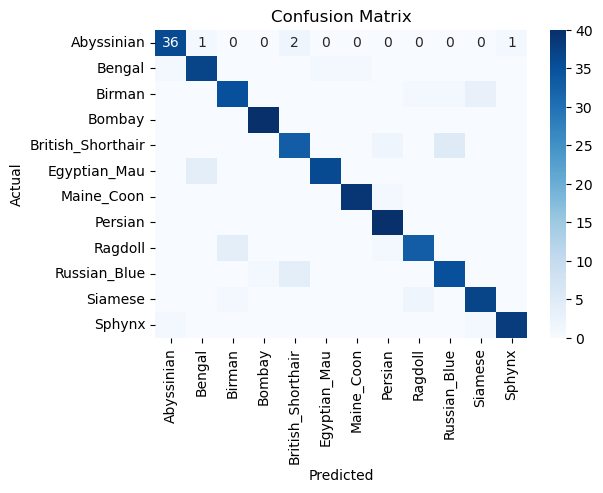


Classification Report:
                   precision    recall  f1-score   support

       Abyssinian       0.95      0.90      0.92        40
           Bengal       0.88      0.93      0.90        40
           Birman       0.88      0.88      0.88        40
           Bombay       0.98      1.00      0.99        40
British_Shorthair       0.85      0.82      0.84        40
     Egyptian_Mau       0.97      0.90      0.94        40
       Maine_Coon       0.97      0.97      0.97        40
          Persian       0.91      1.00      0.95        40
          Ragdoll       0.92      0.87      0.89        38
     Russian_Blue       0.85      0.88      0.86        40
          Siamese       0.90      0.93      0.91        40
           Sphynx       0.97      0.95      0.96        40

         accuracy                           0.92       478
        macro avg       0.92      0.92      0.92       478
     weighted avg       0.92      0.92      0.92       478



In [22]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Melihat hasil classification report
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:")
print(class_report)

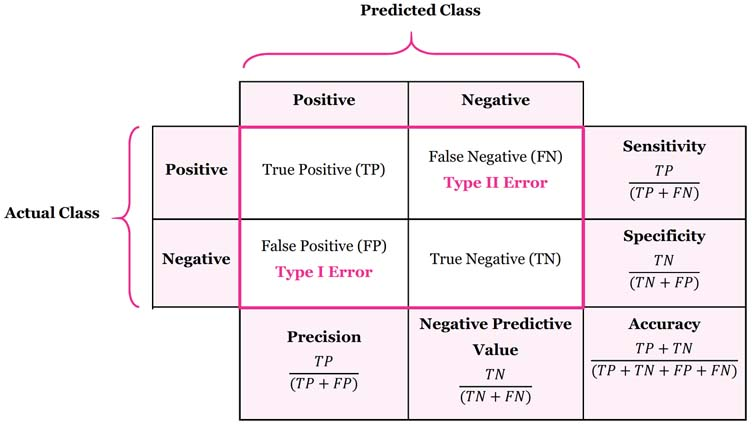

In [23]:
from IPython.display import Image, display

display(Image(filename='gambar/cmatrix.jpg'))

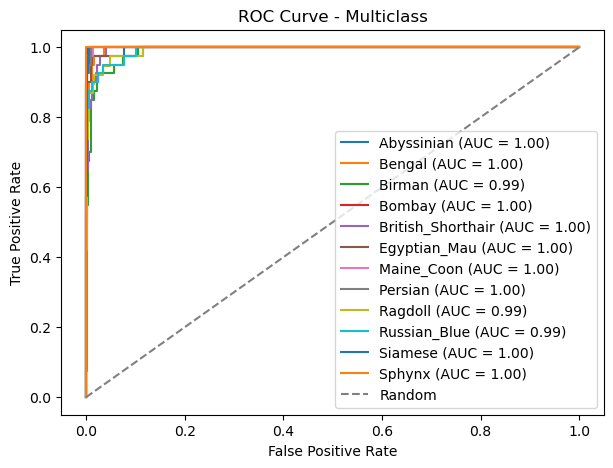

In [24]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve_multiclass(fpr_dict, tpr_dict, roc_auc_dict, class_names):
    plt.figure(figsize=(7, 5))

    for i, class_name in enumerate(class_names):
        plt.plot(fpr_dict[i], tpr_dict[i], label=f'{class_name} (AUC = {roc_auc_dict[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass')
    plt.legend()
    plt.show()

def calculate_roc_auc_multiclass(model, data_loader, device, num_classes):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            labels = labels.view(-1) if len(labels.shape) > 1 else labels
            labels = labels.type(torch.long)

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    # Convert labels to one-hot encoding
    all_labels_onehot = np.eye(num_classes)[all_labels]

    # Convert to numpy arrays
    all_labels_onehot = np.array(all_labels_onehot)
    all_probs = np.array(all_probs)

    # Calculate ROC-AUC for each class
    fpr_dict = {}
    tpr_dict = {}
    roc_auc_dict = {}

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)

        fpr_dict[i] = fpr
        tpr_dict[i] = tpr
        roc_auc_dict[i] = roc_auc

    return fpr_dict, tpr_dict, roc_auc_dict

# Gunakan fungsi ini setelah pelatihan
num_classes = len(class_names)  # Sesuaikan dengan jumlah kelas pada dataset Anda
fpr_dict, tpr_dict, roc_auc_dict = calculate_roc_auc_multiclass(model, test_loader, device, num_classes)
plot_roc_curve_multiclass(fpr_dict, tpr_dict, roc_auc_dict, class_names)

In [28]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Prediksi

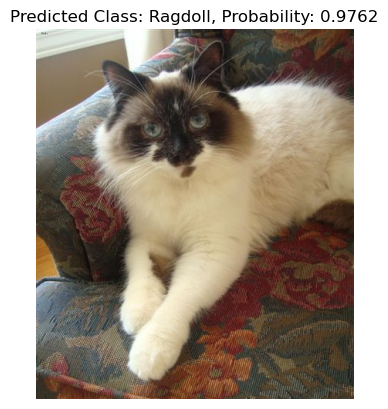

In [38]:
# prediksi

# Function for prediction
def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        output = model(input_tensor)

    # Get predicted class
    _, predicted_class = torch.max(output, 1)
    predicted_class = predicted_class.item()

    # Get prediction probability
    softmax_output = torch.nn.functional.softmax(output, dim=1)
    predicted_probability = softmax_output[0, predicted_class].item()

    # Display the image, predicted class name, and confidence
    display_image(image, predicted_class, predicted_probability)

# Function to display the image, predicted class name, and confidence
def display_image(image, predicted_class, predicted_probability):
    predicted_class_name = class_names[predicted_class]

    plt.imshow(np.asarray(image))
    plt.title(f"Predicted Class: {predicted_class_name}, Probability: {predicted_probability:.4f}")
    plt.axis('off')
    plt.show()

# Example usage
image_path = "dataset_cat/test/Ragdoll/Ragdoll_135.jpg"
predict_image(image_path)


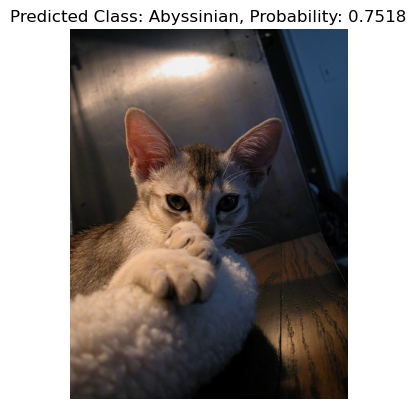

In [32]:
image_path = "dataset_cat/train/Abyssinian/Abyssinian_10.jpg"
predict_image(image_path)

 ### Model Vision Transfomer Dari Awal

# Step 1 

#### Tasks:

1- turn an image into patches

2- flatten the patch feature maps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (196, 768) -> N×(P2⋅C)       #Current shape: (1, 768, 196)

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
# Let's test it on single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    
    
    
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

In [ ]:
x = torch.rand(1,768,14,14)
flatten = nn.Flatten(start_dim=2, end_dim=3)
flat = flatten(x)

flat.shape, flat.permute(0, 2, 1).shape

In [ ]:
# View the patch embedding and patch embedding shape


print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

In [ ]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each


In [ ]:
# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [ ]:
x = torch.rand(1,197,768)
model = MultiheadSelfAttentionBlock()
output = model(x)
output.shape

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x
    


In [ ]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [ ]:
model = ViT(num_classes=12)
x = torch.rand(1,3,224,224)
output = model(x)
output

In [ ]:
model

### Training

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os

model = ViT(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop dengan early stopping dan checkpoint
num_epochs = 50
best_val_loss = float("inf")
early_stopping = EarlyStopping(patience=3, verbose=True)

checkpoint_dir = "model_checkpoints_scratch"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
# os.makedirs(checkpoint_dir, exist_ok=True)

# Lists untuk menyimpan metrik pelatihan
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []

    for inputs, labels in train_loader:
        labels = labels.view(-1) if len(labels.shape) > 1 else labels

        # Ensure labels has data type torch.long
        labels = labels.type(torch.long)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, train_preds = torch.max(outputs, 1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(train_preds.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    all_val_labels = []
    all_val_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.view(-1) if len(labels.shape) > 1 else labels

            # Ensure labels has data type torch.long
            labels = labels.type(torch.long)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, val_preds = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(val_preds.cpu().numpy())

    val_loss /= len(test_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


    # Checkpointing
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch + 1}.pth")
    torch.save(model.state_dict(), checkpoint_path)



In [ ]:
# Plotting train loss and val loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train accuracy and val accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
